In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
from sstcam_simulation import Camera, PixelMapping, PhotoelectronSource
from sstcam_simulation.plotting import CameraImage
camera = Camera(pixel=PixelMapping(n_pixels=8))
pe = PhotoelectronSource(camera=camera, seed=1).get_uniform_illumination(time=100, illumination=1, laser_pulse_width=3)
pe.time[5:] += 50

# Tutorial 3: Event Aquisition - Camera Readout and Trigger

Once you have the photoelectron arrays, the next step is to simulate the camera's response to them. The methods for this are contained within the `EventAcquisition` class. The outputs from these methods can then be used to perform further analysis in order to explore the camera's performance.

In [3]:
from sstcam_simulation.event.acquisition import EventAcquisition
acquisition = EventAcquisition(camera=camera, seed=1)
EventAcquisition?

Init signature: EventAcquisition(camera, seed=None)
Docstring:      <no docstring>
Init docstring:
Collection of methods which simulate operations performed by the camera
electronics for event acquisition (e.g. sampling, trigger,
digitisation), utilising the definitions within the camera container,
and taking in the photoelectron container from the PhotoelectronSource
as input.

Parameters
----------
camera : Camera
    Description of the camera
seed : int or tuple
    Seed for the numpy random number generator.
    Ensures the reproducibility of an event if you know its seed
File:           ~/Software/sstcam-simulation/sstcam_simulation/event/acquisition.py
Type:           type
Subclasses:     


## Continuous readout

The first simulation involved in the aquisition is to emulate the continous readout from the camera. As continuous readout is complicated to simulate, it is instead emulated with a finely sampled array, with a long length. Any photoelectrons that arrived during this readout are convolved with the reference pulse shape. The electronic noise is also included at this step (if it has been included in the camera configuration).

In [4]:
acquisition.get_continuous_readout?

Signature: acquisition.get_continuous_readout(photoelectrons)
Docstring:
Obtain the sudo-continuous readout from the camera for the given
photoelectrons (signal and background) in this event

Parameters
----------
photoelectrons : Photoelectrons
    Container for the photoelectron arrays, obtained from the EventSimulator

Returns
-------
convolved : ndarray
    Array emulating continuous readout from the camera, with the
    photoelectrons convolved with the reference pulse shape
    Units: photoelectrons / ns
    Shape: (n_pixels, n_continuous_readout_samples)
File:      ~/Software/sstcam-simulation/sstcam_simulation/event/acquisition.py
Type:      method


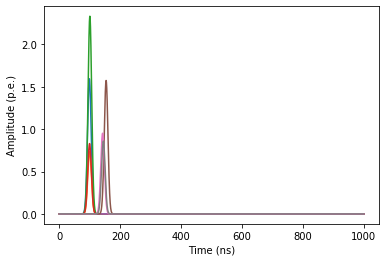

In [5]:
readout = acquisition.get_continuous_readout(pe)
# Divide by peak_height to convert sample units to photoelectrons
plt.plot(camera.continuous_readout_time_axis, readout.T / camera.reference_pulse.peak_height)
plt.xlabel("Time (ns)")
_ = plt.ylabel("Amplitude (p.e.)")

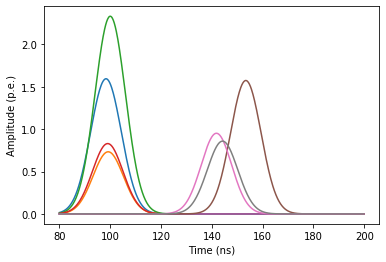

In [6]:
plt.plot(camera.continuous_readout_time_axis[400:1000], readout[:, 400:1000].T / camera.reference_pulse.peak_height)
plt.xlabel("Time (ns)")
_ = plt.ylabel("Amplitude (p.e.)")

## Superpixel Digital Trigger Line

The continuous readout from each pixel is continuously summed with the readout from the other pixels of the same superpixel. This summed readout is then compared with the trigger threshold, to produce a boolean array. To account for the coincidence window (for the backplane trigger between neighbouring superpixels, simulated later) X ns are padded to each True reading.

In [7]:
acquisition.get_superpixel_digital_trigger_line?

Signature: acquisition.get_superpixel_digital_trigger_line(continuous_readout)
Docstring:
Obtain the boolean digital trigger line for each superpixel, based on
if the continuous readout (summed across each superpixel) is above the
trigger threshold, and extending the resulting boolean array to
account for the coincidence window

Parameters
----------
continuous_readout : ndarray
    Array emulating continuous readout from the camera
    Shape: (n_pixels, n_continuous_readout_samples)

Returns
-------
digital_trigger : ndarray
    Boolean array indicating where each superpixel line is "high" (True)
    Shape: (n_superpixels, n_continuous_readout_samples)
File:      ~/Software/sstcam-simulation/sstcam_simulation/event/acquisition.py
Type:      method


In [8]:
camera.update_trigger_threshold(3)
camera.update_coincidence_window(0)
digital = acquisition.get_superpixel_digital_trigger_line(readout)
camera.update_coincidence_window(10)
digital_coincidence = acquisition.get_superpixel_digital_trigger_line(readout)

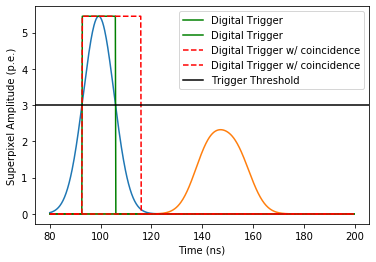

In [9]:
from sstcam_simulation.event.acquisition import sum_superpixels
superpixel_sum = sum_superpixels(readout, camera.pixel.superpixel, camera.superpixel.n_superpixels) / camera.reference_pulse.peak_height
plt.plot(camera.continuous_readout_time_axis[400:1000], superpixel_sum[:, 400:1000].T )
plt.plot(camera.continuous_readout_time_axis[400:1000], digital[:, 400:1000].T * superpixel_sum.max(), 'g-', label="Digital Trigger")
plt.plot(camera.continuous_readout_time_axis[400:1000], digital_coincidence[:, 400:1000].T * superpixel_sum.max(), 'r--', label="Digital Trigger w/ coincidence")
plt.axhline(camera.trigger_threshold, color='black', label='Trigger Threshold')
plt.xlabel("Time (ns)")
plt.ylabel("Superpixel Amplitude (p.e.)")
_ = plt.legend(loc='best')

In [10]:
print("Number of triggers per superpixel: ", acquisition.get_n_superpixel_triggers(digital))

Number of triggers per superpixel:  [1 0]


## Backplane Trigger

If two neighbouring superpixels are high, within the coincidence window length, then a backplane trigger is generated. The time of the trigger occurs on the rising edge of the coincidence (bitwise AND), with the digital trigger sampled every nanosecond.

In [11]:
acquisition.get_backplane_trigger?

Signature: acquisition.get_backplane_trigger(digital_trigger_line)
Docstring:
Get the triggers generated on the backplane by looking for coincidences
in the digital trigger line from neighbouring superpixels

Parameters
----------
digital_trigger_line : ndarray
    Boolean array indicating where each superpixel line is "high" (True)
    Shape: (n_superpixels, n_continuous_readout_samples)

Returns
-------
trigger_time : ndarray
    Time of coincident rising edges between neighbouring superpixels (ns)
    Shape: (n_triggers)
trigger_pair : ndarray
    The two neighbouring superpixels with coincident digital trigger readouts
    Shape: (n_triggers, 2)
File:      ~/Software/sstcam-simulation/sstcam_simulation/event/acquisition.py
Type:      method


N Backplane Triggers:  0


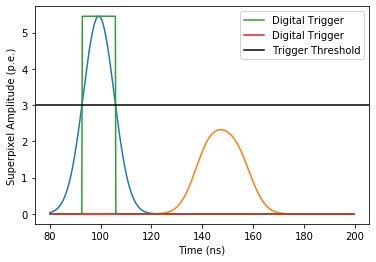

In [12]:
camera.update_trigger_threshold(3)
camera.update_coincidence_window(0)
digital = acquisition.get_superpixel_digital_trigger_line(readout)
backplane_triggers, _ = acquisition.get_backplane_trigger(digital)

superpixel_sum = sum_superpixels(readout, camera.pixel.superpixel, camera.superpixel.n_superpixels) / camera.reference_pulse.peak_height
plt.plot(camera.continuous_readout_time_axis[400:1000], superpixel_sum[:, 400:1000].T )
plt.plot(camera.continuous_readout_time_axis[400:1000], digital[:, 400:1000].T * superpixel_sum.max(), '-', label="Digital Trigger")
plt.axhline(camera.trigger_threshold, color='black', label='Trigger Threshold')
plt.xlabel("Time (ns)")
plt.ylabel("Superpixel Amplitude (p.e.)")
_ = plt.legend(loc='best')

print("N Backplane Triggers: ", backplane_triggers.size)

N Backplane Triggers:  0


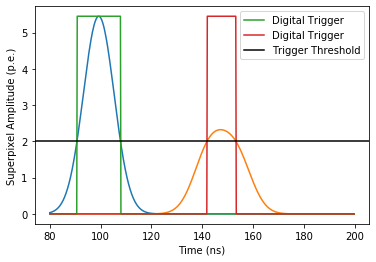

In [13]:
camera.update_trigger_threshold(2)
camera.update_coincidence_window(0)
digital = acquisition.get_superpixel_digital_trigger_line(readout)
backplane_triggers, _ = acquisition.get_backplane_trigger(digital)

superpixel_sum = sum_superpixels(readout, camera.pixel.superpixel, camera.superpixel.n_superpixels) / camera.reference_pulse.peak_height
plt.plot(camera.continuous_readout_time_axis[400:1000], superpixel_sum[:, 400:1000].T )
plt.plot(camera.continuous_readout_time_axis[400:1000], digital[:, 400:1000].T * superpixel_sum.max(), '-', label="Digital Trigger")
plt.axhline(camera.trigger_threshold, color='black', label='Trigger Threshold')
plt.xlabel("Time (ns)")
plt.ylabel("Superpixel Amplitude (p.e.)")
_ = plt.legend(loc='best')

print("N Backplane Triggers: ", backplane_triggers.size)

N Backplane Triggers:  1


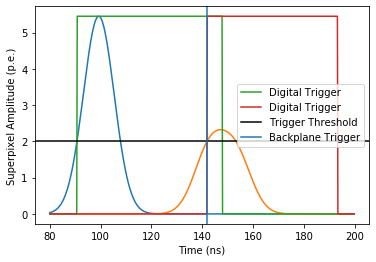

In [14]:
camera.update_trigger_threshold(2)
camera.update_coincidence_window(40)
digital = acquisition.get_superpixel_digital_trigger_line(readout)
backplane_triggers, _ = acquisition.get_backplane_trigger(digital)

superpixel_sum = sum_superpixels(readout, camera.pixel.superpixel, camera.superpixel.n_superpixels) / camera.reference_pulse.peak_height
plt.plot(camera.continuous_readout_time_axis[400:1000], superpixel_sum[:, 400:1000].T )
plt.plot(camera.continuous_readout_time_axis[400:1000], digital[:, 400:1000].T * superpixel_sum.max(), '-', label="Digital Trigger")
plt.axhline(camera.trigger_threshold, color='black', label='Trigger Threshold')
plt.axvline(backplane_triggers, label="Backplane Trigger")
plt.xlabel("Time (ns)")
plt.ylabel("Superpixel Amplitude (p.e.)")
_ = plt.legend(loc='best')

print("N Backplane Triggers: ", backplane_triggers.size)

# Waveform Sampling

Once you have a backplane trigger time, you can produce a sampled waveform readout from the camera. The start of the waveform is defined by the trigger time minus the `lookback_time` (configurable in the camera). The waveform length is also defined in the camera.

In [15]:
acquisition.get_sampled_waveform?

Signature: acquisition.get_sampled_waveform(continuous_readout, trigger_time=None)
Docstring:
Sample the continuous readout into a waveform

Parameters
----------
continuous_readout : ndarray
    Array emulating continuous readout from the camera
    Shape: (n_pixels, n_continuous_readout_samples)
trigger_time : float
    Time of trigger. Start of waveform is dictated by this time minus
    the lookback time. If None (default), then the start of the readout
    is used as the waveform start.

Returns
-------
waveform : ndarray
    Sampled waveform
    Units: photoelectrons
    Shape: (n_pixels, n_samples)
File:      ~/Software/sstcam-simulation/sstcam_simulation/event/acquisition.py
Type:      method


In [16]:
waveform = acquisition.get_sampled_waveform(readout, backplane_triggers[0])
waveform_time_axis = camera.waveform_time_axis + backplane_triggers[0] - camera.lookback_time

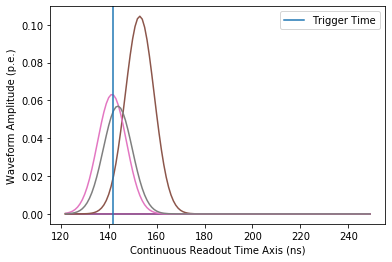

In [17]:
plt.plot(waveform_time_axis, waveform.T)
plt.axvline(backplane_triggers[0], label="Trigger Time")
plt.xlabel("Continuous Readout Time Axis (ns)")
plt.ylabel("Waveform Amplitude (p.e.)")
plt.legend(loc='best')

Alternatively, one can create a sampled waveform from the start of the coninuous readout (useful when you are doing an investigation that does not require the triggering, e.g. Charge Resolution)

In [18]:
waveform = acquisition.get_sampled_waveform(readout)
waveform_time_axis = camera.waveform_time_axis

Text(0, 0.5, 'Waveform Amplitude (p.e.)')

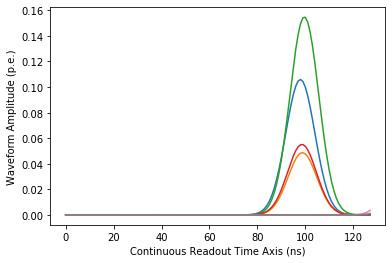

In [19]:
plt.plot(waveform_time_axis, waveform.T)
plt.xlabel("Continuous Readout Time Axis (ns)")
plt.ylabel("Waveform Amplitude (p.e.)")
